## 보팅

In [13]:
from sklearn.datasets import load_iris
from sklearn.ensemble import VotingClassifier

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling  import SMOTE

iris = load_iris()
data = iris.data
target = iris.target

train_x, test_x, train_y, test_y = train_test_split(data, target)

# 조금 다르니 불균형상태라고 보고 smote 처리해서 진행해보겠움!
# (array([0, 1, 2]), array([39, 36, 37], dtype=int64))
np.unique(train_y, return_counts=True)

smote= SMOTE()
train_x2, train_y2 = smote.fit_resample(train_x, train_y)

# 불균형 해결! (array([0, 1, 2]), array([42, 42, 42], dtype=int64))
print(np.unique(train_y2, return_counts=True)) 

lg = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

(array([0, 1, 2]), array([39, 39, 39], dtype=int64))


### hard
다수결


In [14]:
# hard = 다수결
#최소 2개이상이 setosa라고 해야 setosa가 나옴
# 3개나 돌려서 무겁지만, 데이터가 가벼울 시 추천!
voting = VotingClassifier(estimators=[("LG",lg),('KNN',knn),('RF',rf)],
                         voting='hard') 
voting.fit(train_x2, train_y2)

VotingClassifier(estimators=[('LG', LogisticRegression(max_iter=1000)),
                             ('KNN', KNeighborsClassifier()),
                             ('RF', RandomForestClassifier())])

In [15]:
from sklearn.metrics import classification_report

report = classification_report(test_y, voting.predict(test_x))
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.92      0.92      0.92        12
           2       0.93      0.93      0.93        15

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



### softt
평균값

논문을 읽고 대체적으로 soft가 hard보다 성능이 좋다고 볼 수 있음

In [18]:
# soft = 평균값
# setosa라고 예측한 확률들을 평균내서 가장 높은 평균값을 가진 클래스로 분류

voting = VotingClassifier(estimators=[("LG",lg),('KNN',knn),('RF',rf)],
                         voting='soft') 
voting.fit(train_x2, train_y2)

VotingClassifier(estimators=[('LG', LogisticRegression(max_iter=1000)),
                             ('KNN', KNeighborsClassifier()),
                             ('RF', RandomForestClassifier())],
                 voting='soft')

In [19]:
from sklearn.metrics import classification_report

report = classification_report(test_y, voting.predict(test_x))
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.85      0.92      0.88        12
           2       0.93      0.87      0.90        15

    accuracy                           0.92        38
   macro avg       0.92      0.93      0.93        38
weighted avg       0.92      0.92      0.92        38



## 랜덤포레스트
### 그리드 서치

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

iris = load_iris()
data = iris.data
target = iris.target

train_x, test_x, train_y, test_y = train_test_split(data, target)

smote= SMOTE()
train_x2, train_y2 = smote.fit_resample(train_x, train_y)

# 데이터가 만 개, 결정트리 100개
# 기본값 n_estimators 100 (결정트리)
#rf = RandomForestClassifier(n_estimators=1000, max_depth=5)

grid={'n_estimators':range(100, 1000,100),
     'max_depth' : [None] + list(range(1,100,10))}

model= RandomForestClassifier()

# 모든 경우의 수를 시뮬레이션 돌리는 것
grid_search = GridSearchCV(model, param_grid=grid, cv=5,
                          scoring='accuracy')

grid_search.fit(train_x2, train_y2)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 1, 11, 21, 31, 41, 51, 61, 71, 81,
                                       91],
                         'n_estimators': range(100, 1000, 100)},
             scoring='accuracy')

In [23]:
print("최적의 파라미터 : ", grid_search.best_params_)
print("훈련 데이터의 최고 점수 : ", grid_search.best_score_)

최적의 파라미터 :  {'max_depth': None, 'n_estimators': 100}
최고 점수 :  0.975


### 랜덤 서치
랜덤 서치가 그리드 서치보다 최적을 잘 찾을 가능성이 높다         
그리고 랜덤 서치가 더 좋은 결과를 얻을 수 있었다 라는 논문들이 다수 존재   

In [24]:
#cv는 성능을 높인다기보다, 신뢰도를 높이는 것

grid={'n_estimators':range(100, 1000),
     'max_depth' : [None] + list(range(1,100))}

# 랜덤으로 100개만 찾아봐랑!
random_search = RandomizedSearchCV(model,param_distributions=grid,
                                  n_iter=100, cv = 5, scoring='accuracy')

random_search.fit(train_x2, train_y2)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      8, 9, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19, 20,
                                                      21, 22, 23, 24, 25, 26,
                                                      27, 28, 29, ...],
                                        'n_estimators': range(100, 1000)},
                   scoring='accuracy')

In [25]:
print("최적의 파라미터 : ", random_search.best_params_)
print("훈련 데이터의 최고 점수 : ", random_search.best_score_)

최적의 파라미터 :  {'n_estimators': 230, 'max_depth': 57}
훈련 데이터의 최고 점수 :  0.975


In [20]:
# 독립변수와 종속변수와 상관관계가 높을 때는 선형 회귀가 잘 나오는 편!
# 로지스틱이 이진이 가장 나을 수도 있지만, 불가능한 것은 아니당! 무조건 이진할때가 아님!!

# 0305

랜덤포레스트 (결정트리 100개)
- 배깅 : 데이터가 복원 추출
- 부스팅 : 약한 모델로 학습시키면서 틀린 데이터에 가중치를 주는 방법

In [2]:
import pandas as pd

df = pd.read_csv('실습 파일/bike_rentals_cleaned.csv')

### 그레디언트 부스팅 모델 직접 구현 (라이브러리 안쓰고)

그레디언트 부스팅은 오차를 활용해 학습하는 모델

얜 틀린 데이터에 가중치 주는 거 아님! (주는건 adaboost)

결정트리 기반으로 만들어져있음

In [6]:
# 간단 비교라 표준화 안 했음!

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor

X = df.drop('cnt', axis=1)
y = df['cnt']

train_x, test_x, train_y, test_y = train_test_split(X,y)

knn = KNeighborsRegressor()
knn.fit(train_x, train_y)

pred = knn.predict(test_x)

print(mean_absolute_error(test_y, pred))

# RMSE 값
mean_squared_error(test_y, pred)**(1/2)

592.5464480874317


783.1110748983284

In [11]:
# 약한 모델... 일부로 만들었음!
# 훈련데이터와 정답지
dt1 = DecisionTreeRegressor(max_depth=2)
dt1.fit(train_x, train_y)

# 자기가 학습한 거 예측 dt1.predict(train_x)
# 실제값에서 예측값을 뺀 오차값을 알아낸 것
train_y2 = train_y - dt1.predict(train_x)

In [17]:
#  훈련데이터와 전 모델이 얼마나 틀렸는지(오차)를 정답지로 두고 학습
dt2 = DecisionTreeRegressor(max_depth=2)
dt2.fit(train_x, train_y2)

# 전 모델이 얼만큼 틀렸는지 학습
# 또 새로운 오차
train_y3 = train_y2 - dt2.predict(train_x)
train_y3

413      32.155188
237     375.155188
63     1101.831411
615     597.493835
613     205.493835
          ...     
452   -1208.506165
215     290.155188
76     1057.478251
240     348.155188
487     468.846995
Name: cnt, Length: 548, dtype: float64

In [21]:
#  훈련데이터와 전전 모델이 얼마나 틀렸는지(오차)를 정답지로 두고 학습
dt3 = DecisionTreeRegressor(max_depth=2)
dt3.fit(train_x, train_y3)

DecisionTreeRegressor(max_depth=2)

In [22]:
# 시험데이터 적용
pred1 = dt1.predict(test_x)
pred2 = dt2.predict(test_x)
pred3 = dt3.predict(test_x)

In [26]:
pred = pred1+pred2+pred3

In [25]:
mean_squared_error(test_y, pred)**(1/2)

895.8183779138191

### 그레디언트 부스팅 모델 라이브러리 사용

xgboost는 이 모델보다 캐시메모리, 병렬처리 등 속도가 빠른것이 강점 근데 얘도 그레디언트 부스팅 모델 기반이라서 둘다 좋음!


In [28]:
from sklearn.ensemble import GradientBoostingRegressor
# 직접 구현한 거 처럼 적은 거임! max_depth =2, dt3 까지라서 n_estimators=3
# learning rate 의 기본값은 0.1 => 전 모델이 얼마나 틀렸는지 보고 학습하는 것
# 근데 그대로 주면 빠르게 과적합이 되기 때문에, 다음 모델에 0.1정도의 오차를 주고 보내는 것


gbr = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1)
gbr.fit(train_x, train_y)

pred = gbr.predict(test_x)
mean_squared_error(test_y, pred)**(1/2)

895.8183779138193

In [37]:
# 그래서 n_estimators가 높으면 높을수록 learning_rate는 작게 적용해주는게 좋음!

from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

box = []
for i in np.arange(0.1, 1, 0.1):

    gbr = GradientBoostingRegressor(learning_rate=i, n_estimators=3000) # 3000 10 (그래프가 감소했다가 증가해서 과적합 진행중..?)없을때 등 해보기
    gbr.fit(train_x, train_y)
    pred = gbr.predict(test_x)
    rmse = mean_squared_error(test_y, pred) ** (1/2)
    box.append(rmse)

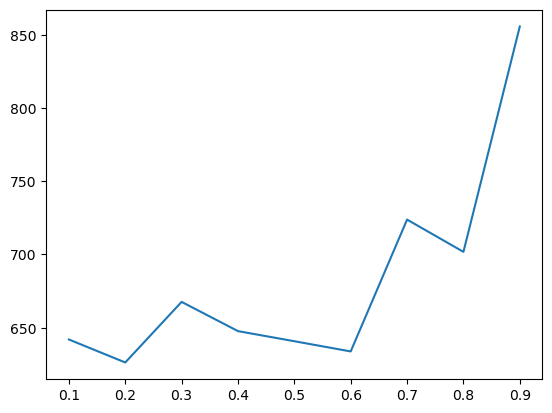

In [38]:
import matplotlib.pyplot as plt

# 가지수가 많으며 학습률이 높을수록 과대적합이 빨리 난다는 것
plt.plot(np.arange(0.1,1,0.1), box)
plt.show()

In [29]:
# 결측치 처리도 필요없음...
# 누락값이 있는 데이터는 왼쪽으로 가라 있으면 오른쪽으로 가라 처럼 학습에 이용함
from xgboost import XGBClassifier, XGBRegressor

